In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
ntuple = "/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_MX_1000_MY_600/ntuple.root"
model = "/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixb/weaver-multiH/weaver/models/exp_xy/XY_3H_reco_ranker/20230213_ranger_lr0.0047_batch1024__full_reco_withbkg/"

In [4]:
import uproot as ut 

tree = ut.lazy(f'{ntuple}:sixBtree')

In [9]:
self = tree
self.nevents = len(tree)

In [10]:
awkd_model = f'{model}/predict_output/MX_1000_MY_600.awkd'

import awkward0 as ak0

with ak0.load(awkd_model) as f_awk:
    self.scores = ak.unflatten(f_awk['scores'], np.repeat(45, self.nevents)).to_numpy()
    self.maxscore = f_awk['maxscore']
    self.maxcomb = f_awk['maxcomb']
    self.maxlabel = f_awk['maxlabel']

In [12]:
combos = self.maxcomb
combos = ak.from_regular(combos)

In [15]:
pt = self.jet_ptRegressed[combos]
phi = self.jet_phi[combos]
eta = self.jet_eta[combos]
m = self.jet_mRegressed[combos]
btag = self.jet_btag[combos]
sig_id = self.jet_signalId[combos]
h_id = (self.jet_signalId[combos] + 2) // 2

In [21]:
class Particle:
    def __init__(self, kin_dict=dict()):
        self.__dict__.update(**kin_dict)
    def set_attr(self, key, value):
        self.__dict__[key] = value
    @property
    def p4(self):
        return ak.zip(
            {
                'pt':self.pt,
                'eta':self.eta,
                'phi':self.phi,
                'm':self.m
            }, with_name='Momentum4D'
        )

In [22]:
sample_particles = []
for j in range(6):
    particle = Particle(kin_dict={
        'pt' : pt[:,j],
        'eta' : eta[:,j],
        'phi' : phi[:,j],
        'm' : m[:,j],
        }
    )
    particle.set_attr('btag',btag[:,j])
    particle.set_attr('sig_id', sig_id[:,j])
    particle.set_attr('h_id', h_id[:,j])
    sample_particles.append(particle)

In [24]:
self.HX_b1 = sample_particles[0].p4
self.HX_b2 = sample_particles[1].p4
self.H1_b1 = sample_particles[2].p4
self.H1_b2 = sample_particles[3].p4
self.H2_b1 = sample_particles[4].p4
self.H2_b2 = sample_particles[5].p4

In [25]:
self.HX = self.HX_b1 + self.HX_b2
self.H1 = self.H1_b1 + self.H1_b2
self.H2 = self.H2_b1 + self.H2_b2

In [27]:
self.Y = self.H1 + self.H2
self.X = self.HX + self.H1 + self.H2

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:ylabel='PDF'>,
 [HistoList<[<utils.plotUtils.histogram.Histo object at 0x7ff060844820>]>])

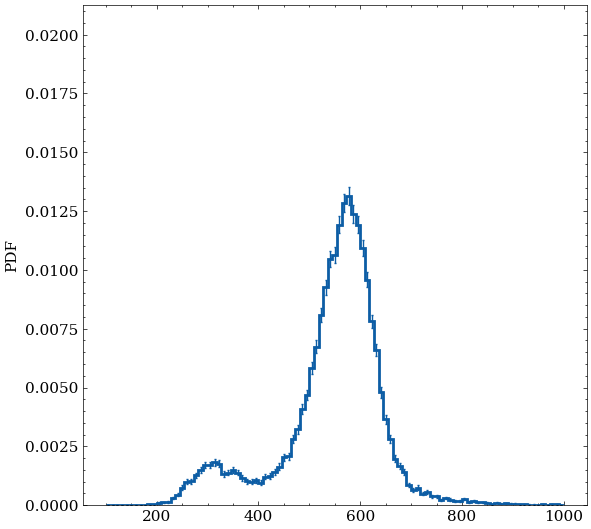

In [31]:
hist_multi([self.Y.m[self.nfound_select==6]], bins=np.linspace(100,1000,100), density=True)